In [1]:
from datetime import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import statistics as stats
from matplotlib import pyplot as plt
from hmmlearn import hmm
from utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# constants
MOVING_AVERAGE_WINDOW_SIZE = 30
PREDICTION_WINDOW_SIZE = 50
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4

In [3]:
def show_graph(data):
    plt.plot(data['DCOILWTICO'])
    plt.xlabel('Date')
    plt.ylabel('Oil Prices')
    plt.title('Trend of Crude Oil Prices')
    plt.show()

def split_to_prediction_windows(data, prediction_window):
    x = []
    y = []
    for i in range(prediction_window, len(data)):
        x.append(data[i - prediction_window: i, 0])
        y.append(data[i, 0])
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], 1)
    return x, np.array(y)

def generate_train_test_prediction_windows(train, test, prediction_window_size):
    x_train, y_train = split_to_prediction_windows(train, prediction_window_size)
    x_test, y_test = split_to_prediction_windows(test, prediction_window_size)
    return x_train, y_train, x_test, y_test

In [4]:
oil_prices = pd.read_csv('oil_prices.csv', index_col='DATE', parse_dates=['DATE'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())
oil_prices = oil_prices[oil_prices['DCOILWTICO'] != '.']
oil_prices['DCOILWTICO'] = pd.to_numeric(oil_prices['DCOILWTICO'])
oil_prices.head()

,DCOILWTICO
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


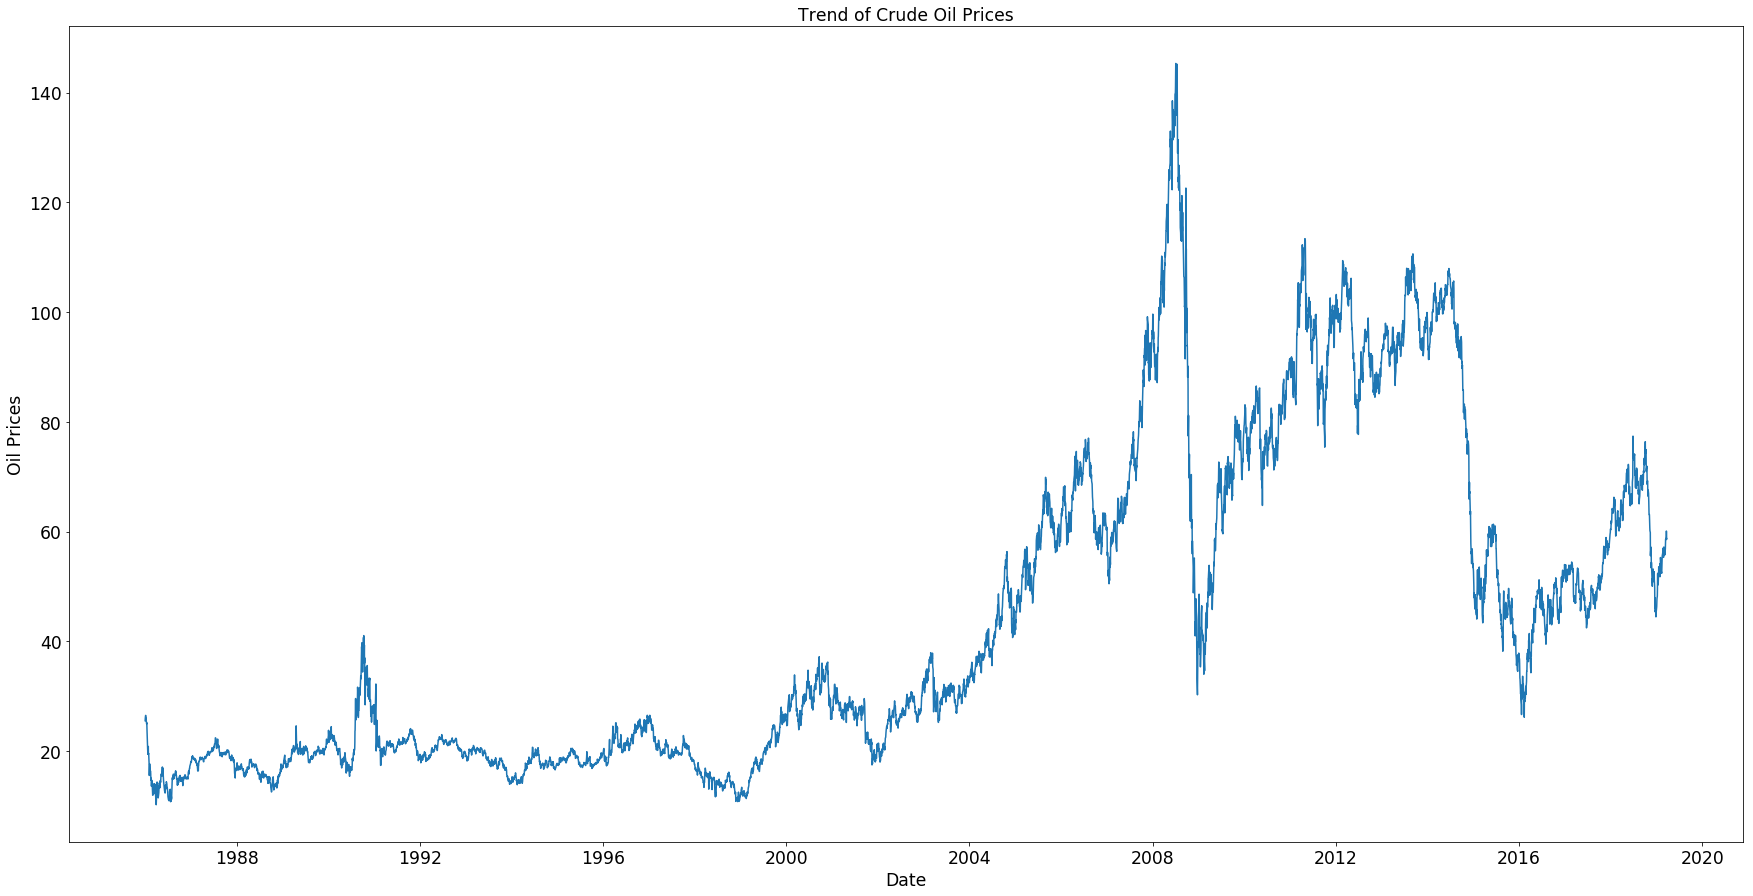

In [5]:
show_graph(oil_prices)

In [6]:
averages, trends = get_moving_window_dataframes(oil_prices, MOVING_AVERAGE_WINDOW_SIZE)

In [7]:
averages.head()

,DCOILWTICO
0,21.224667
1,20.920333
2,20.588000
3,20.193667
4,19.834667


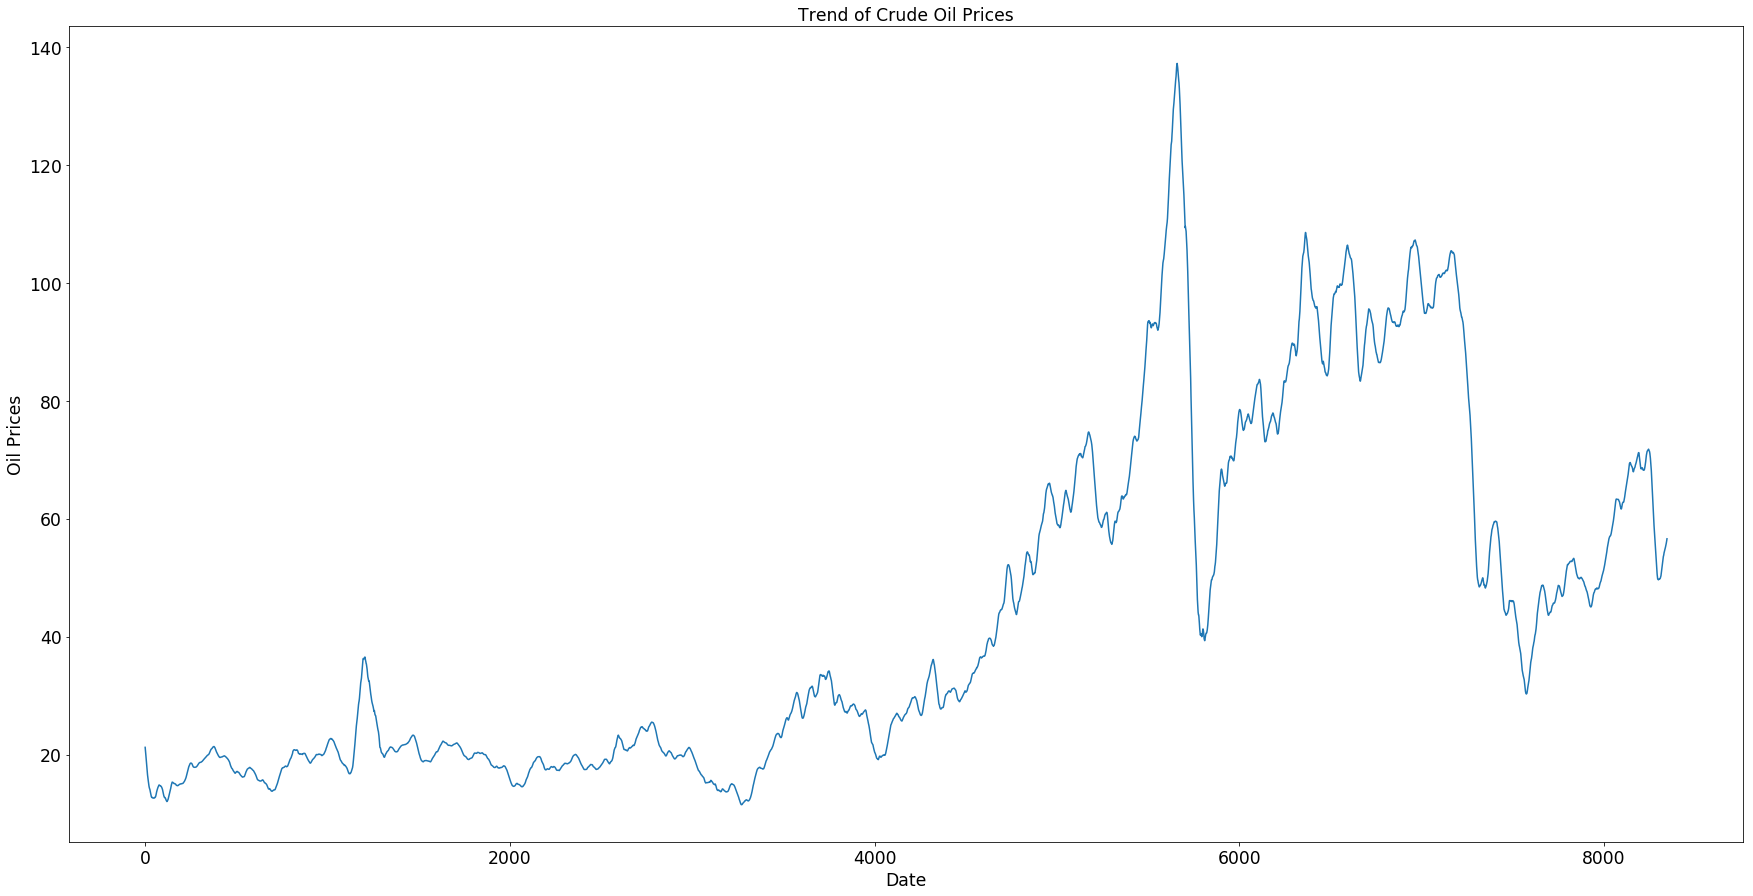

In [8]:
show_graph(averages)

# Hidden Markov Model

In [22]:
recent_trends = trends[-3000:].as_matrix().astype(int)
remodel = hmm.MultinomialHMM(n_components=5, n_iter=200)
remodel.fit(recent_trends[:2000])
test_set = recent_trends[2000:]
predictions = remodel.predict(test_set)
accuracy = (predictions == test_set.flatten()).sum() * 100 / len(predictions)
'Accuracy for Hidden Markov Model is {}%.'.format(accuracy)

/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


'Accuracy for Hidden Markov Model is 88.1%.'

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
matrix = scaler.fit_transform(averages[-3000:])
matrix_train = matrix[:2000]
matrix_test = matrix[2000:]
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(matrix_train, matrix_test, PREDICTION_WINDOW_SIZE)

# RNN Model

In [11]:
rnn_model, rnn_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'rnn', EPOCH, BATCH_SIZE)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1950/1950 [==============================] - 3s 1ms/step - loss: 0.3878
Epoch 2/100
1950/1950 [==============================] - 2s 1ms/step - loss: 0.2254
Epoch 3/100
1950/1950 [==============================] - 2s 1ms/step - loss: 0.1446
Epoch 4/100
1950/1950 [==============================] - 2s 1ms/step - loss: 0.0886
Epoch 5/100
1950/1950 [==============================] - 2s 1ms/step - loss: 0.0599
Epoch 6/100
1950/1950 [==============================] - 2s 1ms/step - loss: 0.0436
Epoch 7/100
1950/1950 [==============================] - 3s 1ms/step - loss: 0.0269
Epoch 8/100
1950/1950 [==============================] - 3s 2ms/step - loss: 0.0170
Epoch 9/100
1950/1950 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 10/

1950/1950 [==============================] - 4s 2ms/step - loss: 7.2222e-04
Epoch 86/100
1950/1950 [==============================] - 3s 2ms/step - loss: 6.2845e-04
Epoch 87/100
1950/1950 [==============================] - 4s 2ms/step - loss: 5.9861e-04
Epoch 88/100
1950/1950 [==============================] - 3s 2ms/step - loss: 6.7601e-04
Epoch 89/100
1950/1950 [==============================] - 3s 2ms/step - loss: 6.4879e-04
Epoch 90/100
1950/1950 [==============================] - 3s 2ms/step - loss: 9.3695e-04
Epoch 91/100
1950/1950 [==============================] - 4s 2ms/step - loss: 5.5067e-04
Epoch 92/100
1950/1950 [==============================] - 4s 2ms/step - loss: 6.4121e-04
Epoch 93/100
1950/1950 [==============================] - 3s 2ms/step - loss: 5.7378e-04
Epoch 94/100
1950/1950 [==============================] - 3s 2ms/step - loss: 6.5474e-04
Epoch 95/100
1950/1950 [==============================] - 3s 2ms/step - loss: 6.5101e-04
Epoch 96/100
1950/1950 [==========

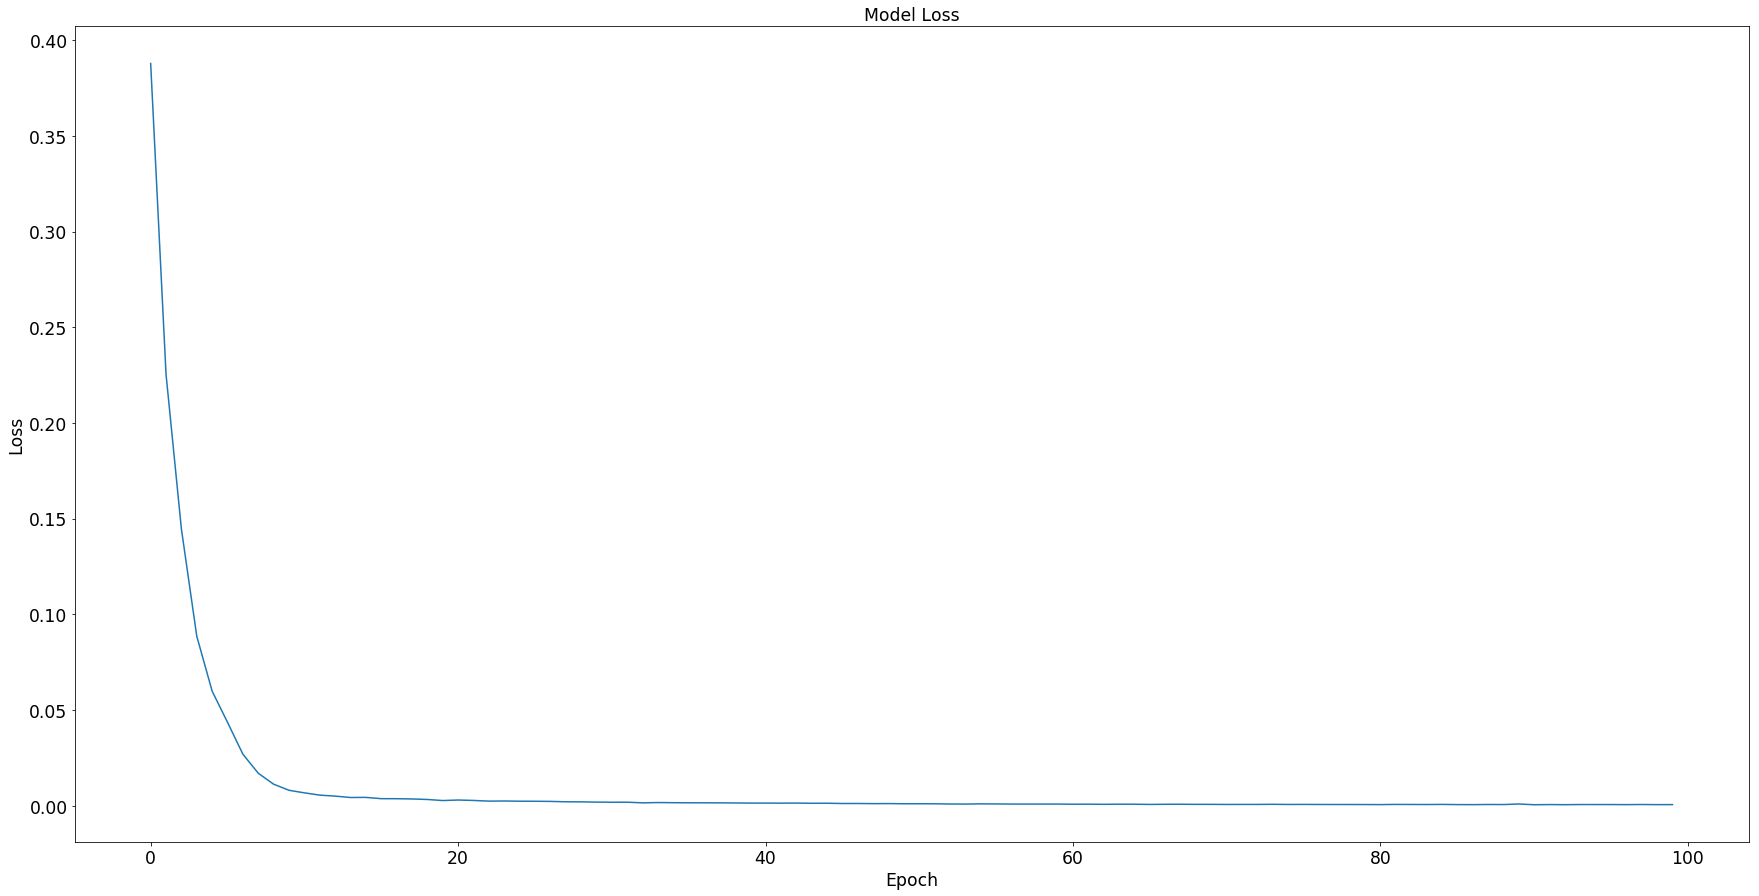

In [12]:
plot_loss(rnn_history)

# LSTM Model

In [13]:
lstm_model, lstm_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'lstm', EPOCH, BATCH_SIZE)

Epoch 1/100
1950/1950 [==============================] - 16s 8ms/step - loss: 0.0250
Epoch 2/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0106
Epoch 3/100
1950/1950 [==============================] - 11s 6ms/step - loss: 0.0090
Epoch 4/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0077
Epoch 5/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0060
Epoch 6/100
1950/1950 [==============================] - 13s 7ms/step - loss: 0.0051
Epoch 7/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0047
Epoch 8/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0042
Epoch 9/100
1950/1950 [==============================] - 11s 6ms/step - loss: 0.0041
Epoch 10/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0035
Epoch 11/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0034
Epoch 12/100
1950/1950 [==============================] - 14s 7

1950/1950 [==============================] - 9s 5ms/step - loss: 4.7818e-04
Epoch 95/100
1950/1950 [==============================] - 9s 5ms/step - loss: 4.3655e-04
Epoch 96/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.8242e-04
Epoch 97/100
1950/1950 [==============================] - 9s 5ms/step - loss: 4.9559e-04
Epoch 98/100
1950/1950 [==============================] - 9s 5ms/step - loss: 4.9009e-04
Epoch 99/100
1950/1950 [==============================] - 9s 5ms/step - loss: 5.2337e-04
Epoch 100/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.1894e-04


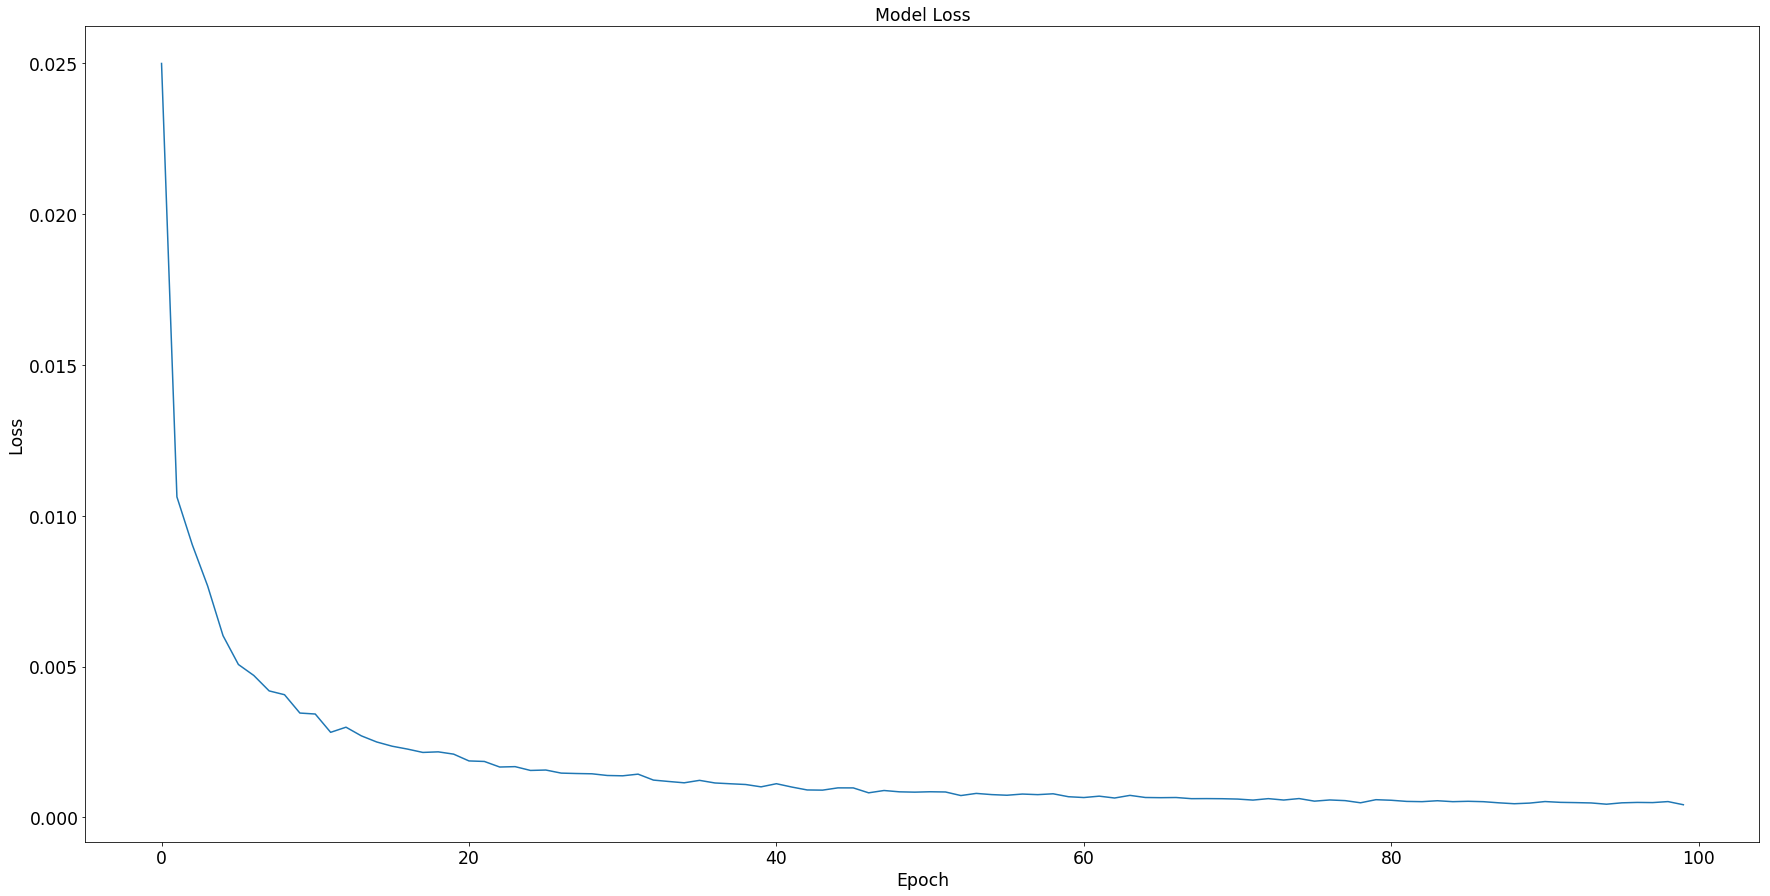

In [14]:
plot_loss(lstm_history)

# GRU Model

In [15]:
gru_model, gru_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'gru', EPOCH, BATCH_SIZE)

Epoch 1/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0175
Epoch 2/100
1950/1950 [==============================] - 8s 4ms/step - loss: 0.0079
Epoch 3/100
1950/1950 [==============================] - 8s 4ms/step - loss: 0.0066
Epoch 4/100
1950/1950 [==============================] - 8s 4ms/step - loss: 0.0055
Epoch 5/100
1950/1950 [==============================] - 9s 5ms/step - loss: 0.0055
Epoch 6/100
1950/1950 [==============================] - 11s 5ms/step - loss: 0.0046
Epoch 7/100
1950/1950 [==============================] - 11s 5ms/step - loss: 0.0041
Epoch 8/100
1950/1950 [==============================] - 11s 6ms/step - loss: 0.0040
Epoch 9/100
1950/1950 [==============================] - 10s 5ms/step - loss: 0.0032
Epoch 10/100
1950/1950 [==============================] - 10s 5ms/step - loss: 0.0033
Epoch 11/100
1950/1950 [==============================] - 10s 5ms/step - loss: 0.0031
Epoch 12/100
1950/1950 [==============================] - 10s 5ms/s

1950/1950 [==============================] - 10s 5ms/step - loss: 3.9812e-04
Epoch 95/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.2922e-04
Epoch 96/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.0260e-04
Epoch 97/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.5788e-04
Epoch 98/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.2765e-04
Epoch 99/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.0539e-04
Epoch 100/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.0181e-04


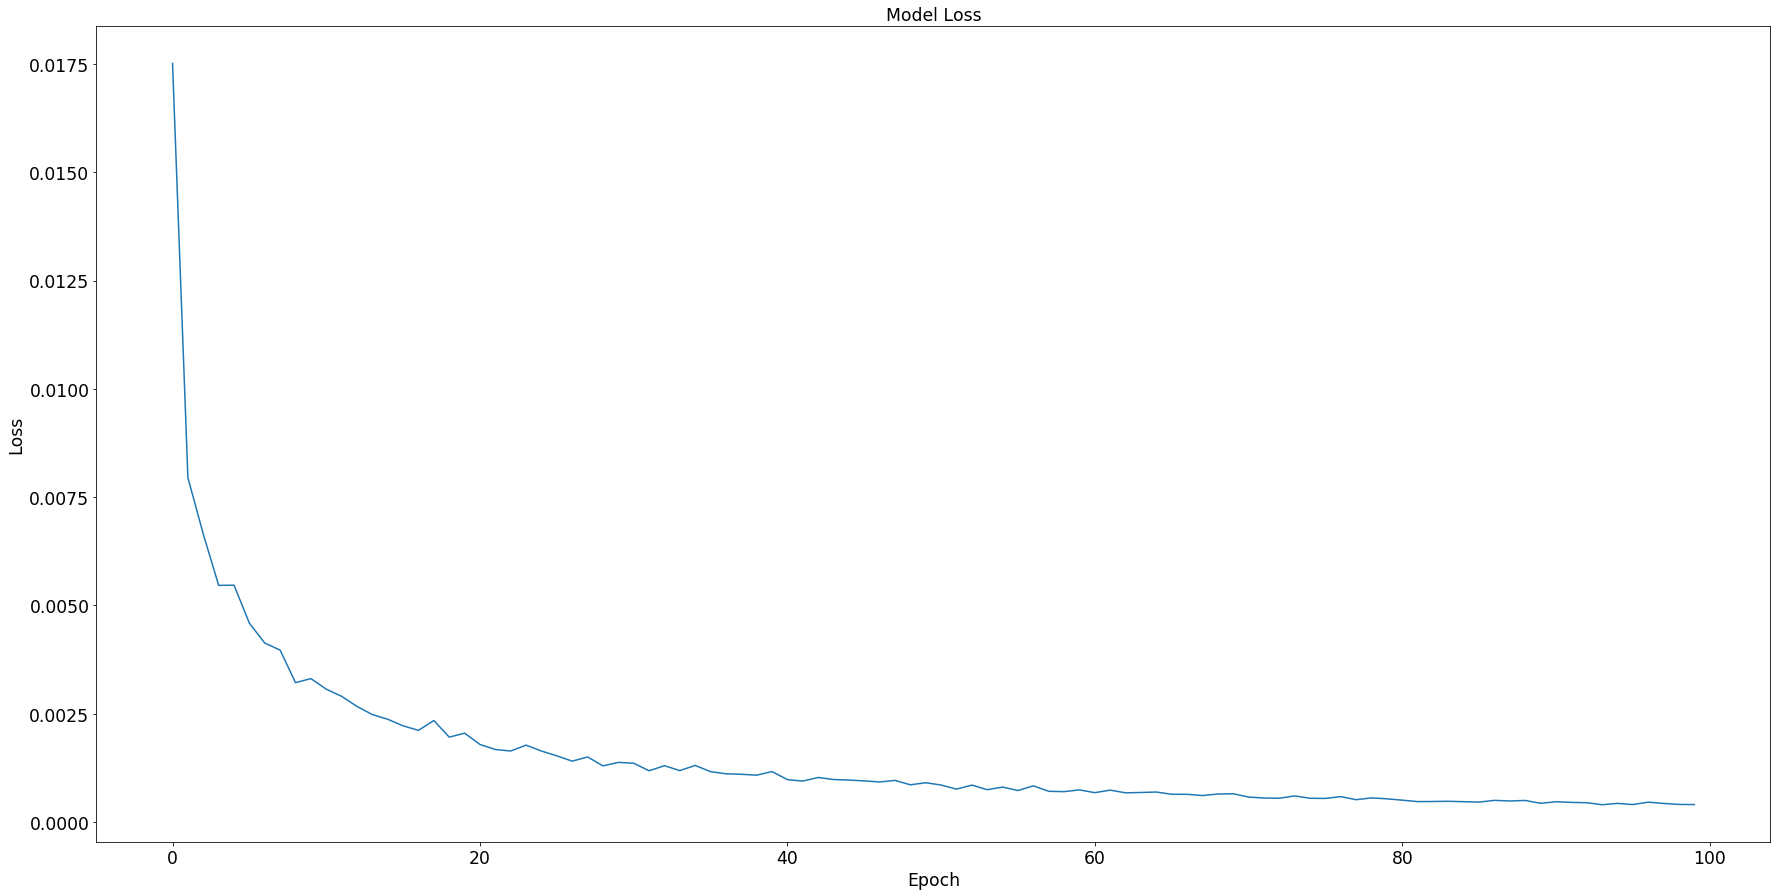

In [16]:
plot_loss(gru_history)

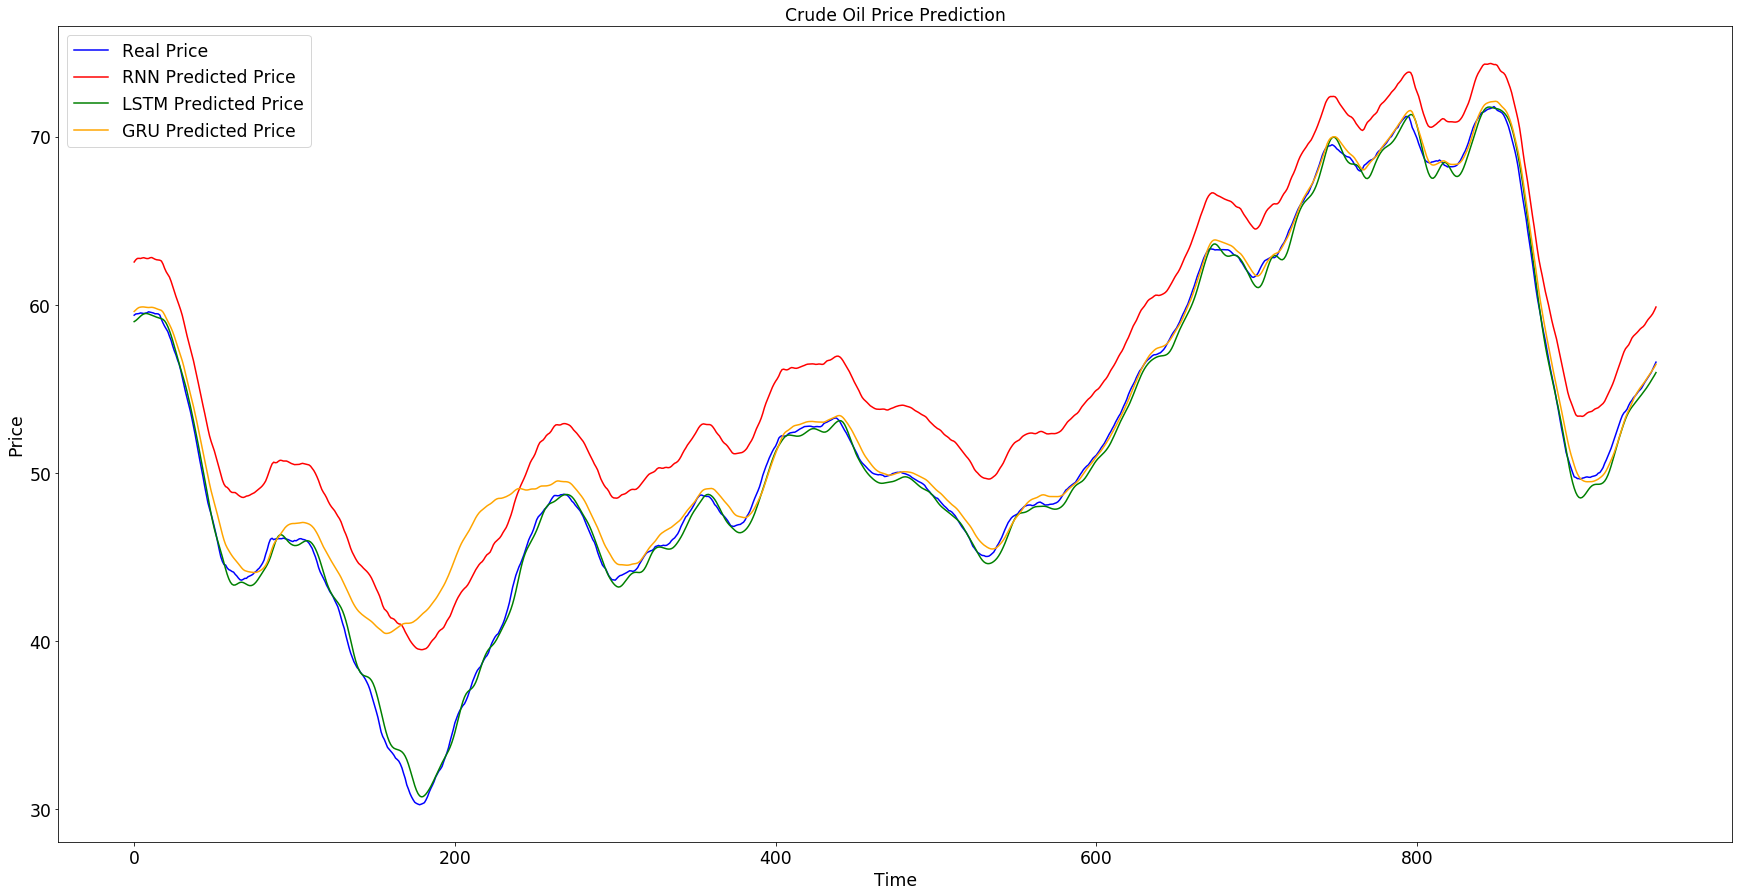

In [17]:
plot_prediction(scaler, x_test, y_test, [('RNN', rnn_model, 'red'), ('LSTM', lstm_model, 'green'), ('GRU', gru_model, 'orange')])

In [18]:
rnn_mse = calculate_mse(x_test, y_test, rnn_model)
print('Mean Square Error for RNN is {}.'.format(rnn_mse))
lstm_mse = calculate_mse(x_test, y_test, lstm_model)
print('Mean Square Error for LSTM is {}.'.format(lstm_mse))
gru_mse = calculate_mse(x_test, y_test, gru_model)
print('Mean Square Error for GRU is {}.'.format(gru_mse))

Mean Square Error for RNN is [0.00165196].
Mean Square Error for LSTM is [2.0180305e-05].
Mean Square Error for GRU is [0.00073834].
